In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


LS Part

----- Processing Linearly Separable Data -----


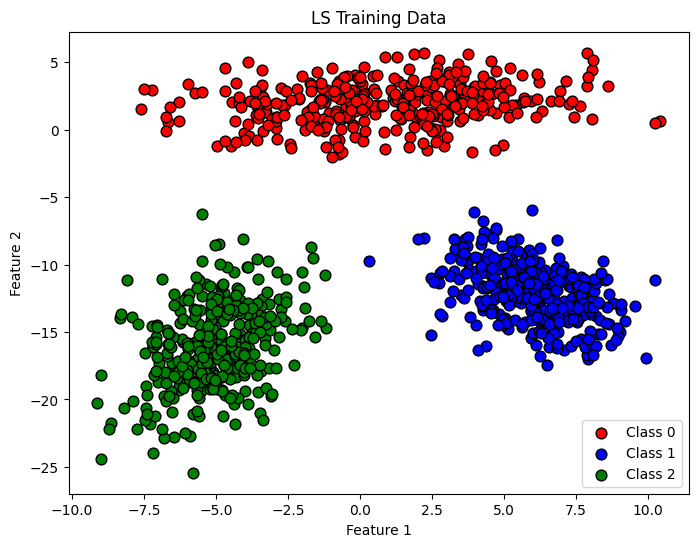

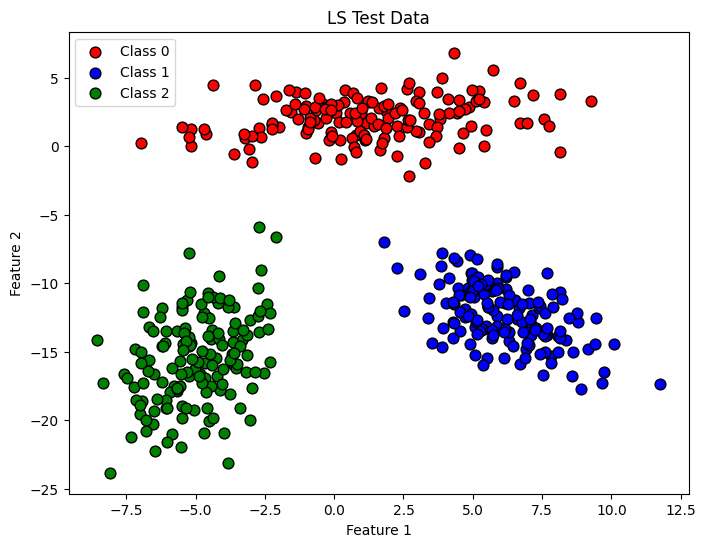

Training classifier for classes 0 vs 1
Epoch 0, Average Error: 0.02723948524200455
Epoch 100, Average Error: 0.00016659524045864184
Early stopping at epoch 178, Average Error: 9.952496869808944e-05
Training classifier for classes 0 vs 2
Epoch 0, Average Error: 0.02694575061284817
Epoch 100, Average Error: 0.00014904994738693057
Early stopping at epoch 157, Average Error: 9.970240451898783e-05
Training classifier for classes 1 vs 2
Epoch 0, Average Error: 0.005657374844023783
Epoch 100, Average Error: 0.00012234935908093301
Early stopping at epoch 137, Average Error: 9.961238978687265e-05


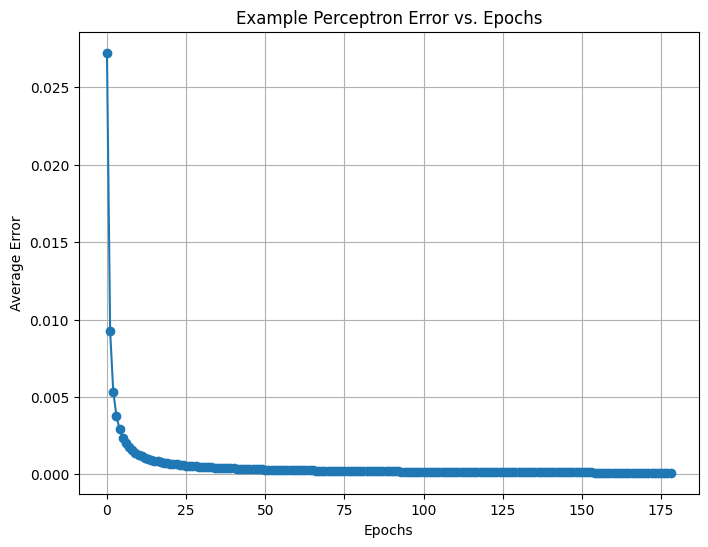

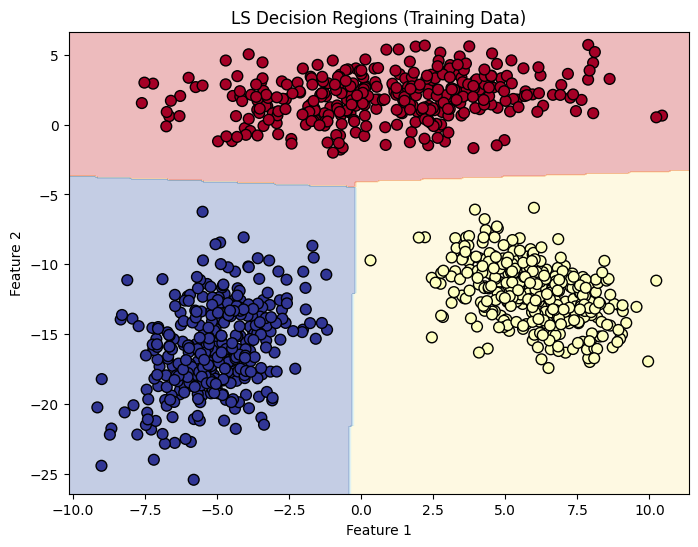

Accuracy on LS Test Data: 100.00%
Confusion Matrix on LS Test Data:
[[150   0   0]
 [  0 150   0]
 [  0   0 150]]


(100.0,
 array([[150,   0,   0],
        [  0, 150,   0],
        [  0,   0, 150]]))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# We'll gather data from a text file for a specific class and label it accordingly.
def load_class_data(file_path, class_label):
    data = np.loadtxt(file_path)
    X = data[:, :-1] if data.shape[1] > 2 else data
    y = np.full(data.shape[0], class_label)
    return X, y

# We combine data from all three classes (class1, class2, class3),
# then split into train and test sets, ensuring a 70-30 split.
def load_ls_data():
    path1 = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-1/LS/Class1.txt'
    path2 = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-1/LS/Class2.txt'
    path3 = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-1/LS/Class3.txt'
    X1, y1 = load_class_data(path1, 0)
    X2, y2 = load_class_data(path2, 1)
    X3, y3 = load_class_data(path3, 2)

    X_ls = np.vstack((X1, X2, X3))
    y_ls = np.concatenate((y1, y2, y3))
    X_train, X_test, y_train, y_test = train_test_split(
        X_ls, y_ls, test_size=0.3, random_state=42, stratify=y_ls
    )
    return X_train, X_test, y_train, y_test

# Sigmoid function to squeeze values into (0,1).
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid for backprop, given the sigmoid output.
def sigmoid_derivative(output):
    return output * (1 - output)

# This Perceptron class uses sigmoid activation and does backprop by itself.
class Perceptron:
    def __init__(self, input_size, learning_rate=0.01, epochs=1000, tol=1e-4):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.weights = np.random.randn(input_size) * 0.01
        self.bias = np.random.randn() * 0.01
        self.errors = []

    def forward(self, X):
        return np.dot(X, self.weights) + self.bias

    def predict(self, X):
        return sigmoid(self.forward(X))

    def train(self, X, y):
        self.errors = []
        for epoch in range(self.epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            total_error = 0
            for xi, yi in zip(X_shuffled, y_shuffled):
                output = self.predict(xi)
                error = yi - output
                total_error += error**2
                deriv = sigmoid_derivative(output)
                self.weights += self.learning_rate * error * deriv * xi
                self.bias += self.learning_rate * error * deriv

            avg_error = total_error / X.shape[0]
            self.errors.append(avg_error)

            if avg_error < self.tol:
                print(f"Early stopping at epoch {epoch}, Average Error: {avg_error}")
                break

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Average Error: {avg_error}")
        return self.errors

# We use One-Against-One approach for multi-class classification:
# train separate Perceptrons for each pair of classes.
class OAO_Perceptron:
    def __init__(self, input_size, learning_rate=0.01, epochs=1000, tol=1e-4):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.classifiers = []
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for i in range(len(self.classes_)):
            for j in range(i+1, len(self.classes_)):
                idx = np.where((y == self.classes_[i]) | (y == self.classes_[j]))[0]
                X_pair = X[idx]
                y_pair = y[idx]
                binary_labels = np.where(y_pair == self.classes_[i], 0, 1)
                perceptron = Perceptron(self.input_size, self.learning_rate, self.epochs, self.tol)
                print(f"Training classifier for classes {self.classes_[i]} vs {self.classes_[j]}")
                perceptron.train(X_pair, binary_labels)
                self.classifiers.append((self.classes_[i], self.classes_[j], perceptron))

    def predict(self, X):
        votes = np.zeros(len(self.classes_))
        for (class_i, class_j, perceptron) in self.classifiers:
            pred = np.round(perceptron.predict(X))
            if pred == 0:
                votes[np.where(self.classes_ == class_i)[0][0]] += 1
            else:
                votes[np.where(self.classes_ == class_j)[0][0]] += 1
        return self.classes_[np.argmax(votes)]

    def predict_batch(self, X):
        return np.array([self.predict(x) for x in X])

    def evaluate(self, X, y, dataset_name="Dataset"):
        y_pred = self.predict_batch(X)
        acc = accuracy_score(y, y_pred) * 100
        cm = confusion_matrix(y, y_pred)
        print(f"Accuracy on {dataset_name}: {acc:.2f}%")
        print(f"Confusion Matrix on {dataset_name}:\n{cm}")
        return acc, cm

# We draw the data in 2D space, color-coded by class.
def plot_data(X, y, title="Data", xlabel="Feature 1", ylabel="Feature 2"):
    plt.figure(figsize=(8, 6))
    classes = np.unique(y)
    colors = ['red', 'blue', 'green']
    for idx, cls in enumerate(classes):
        plt.scatter(X[y == cls, 0], X[y == cls, 1],
                    color=colors[idx], label=f"Class {cls}",
                    edgecolors='k', s=60)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# This one plots error vs. epochs for a single Perceptron.
def plot_error_vs_epochs(errors, title="Average Error vs. Epochs"):
    plt.figure(figsize=(8, 6))
    plt.plot(errors, marker='o')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Average Error")
    plt.grid(True)
    plt.show()

# We'll show decision boundaries in 2D by predicting across a grid of points.
def plot_decision_regions(model, X, y, title="Decision Regions", resolution=0.1):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = model.predict_batch(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdYlBu, s=60)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

print("----- Processing Linearly Separable Data -----")
X_train_ls, X_test_ls, y_train_ls, y_test_ls = load_ls_data()
plot_data(X_train_ls, y_train_ls, title="LS Training Data")
plot_data(X_test_ls, y_test_ls, title="LS Test Data")

input_size = X_train_ls.shape[1]
oao_model = OAO_Perceptron(input_size, learning_rate=0.1, epochs=1000, tol=1e-4)
oao_model.fit(X_train_ls, y_train_ls)

if oao_model.classifiers:
    _, _, example_perceptron = oao_model.classifiers[0]
    plot_error_vs_epochs(example_perceptron.errors, title="Example Perceptron Error vs. Epochs")

plot_decision_regions(oao_model, X_train_ls, y_train_ls, title="LS Decision Regions (Training Data)")
oao_model.evaluate(X_test_ls, y_test_ls, dataset_name="LS Test Data")


NLS Part

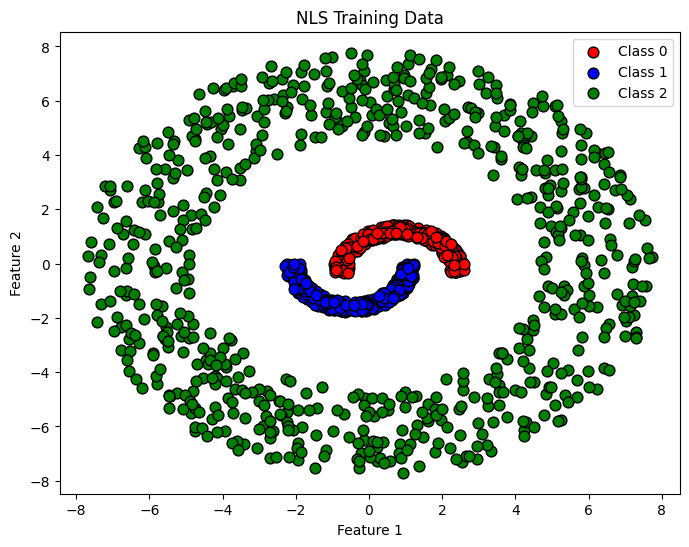

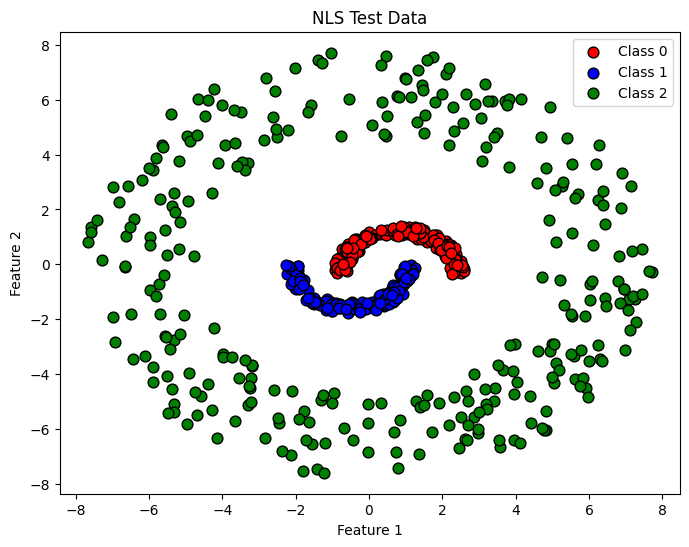

Original feature shape: (1400, 2)
Transformed feature shape: (1400, 5)
----- Processing Nonlinearly Separable Data -----


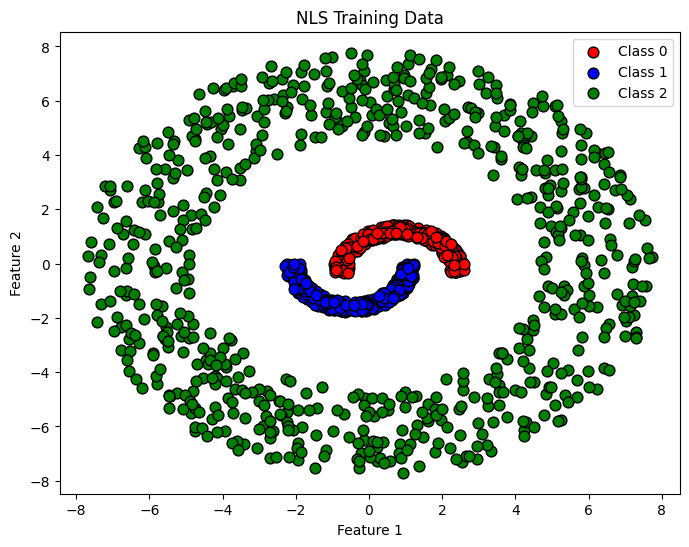

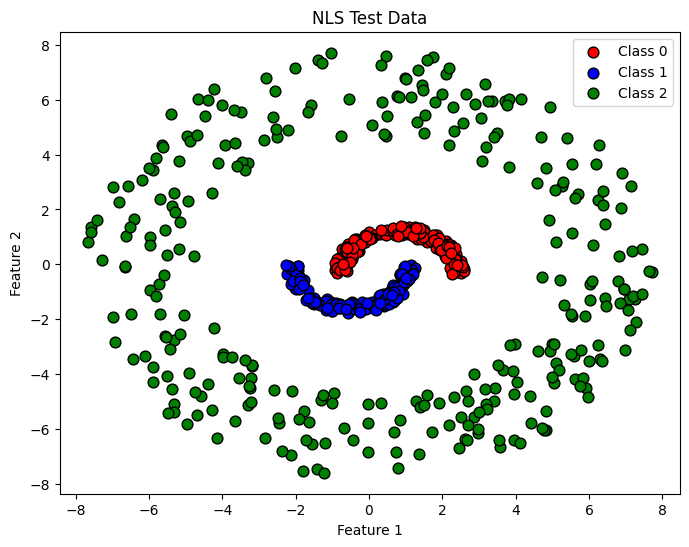

Original feature shape: (1400, 2)
Transformed feature shape: (1400, 5)
Training classifier for classes 0 vs 1
Epoch 0, Average Error: 0.08330174189071818
Epoch 100, Average Error: 0.03433655897456893
Epoch 200, Average Error: 0.03337718481470106
Epoch 300, Average Error: 0.032653137688219536
Epoch 400, Average Error: 0.032037242702102134
Epoch 500, Average Error: 0.03153442669791872
Epoch 600, Average Error: 0.031194654659230464
Epoch 700, Average Error: 0.030851733548019625
Epoch 800, Average Error: 0.03059735188679458
Epoch 900, Average Error: 0.030383151590488176
Training classifier for classes 0 vs 2
Epoch 0, Average Error: 0.03322259544756821
Early stopping at epoch 84, Average Error: 9.988740339006667e-05
Training classifier for classes 1 vs 2
Epoch 0, Average Error: 0.030941065614320258
Early stopping at epoch 75, Average Error: 9.960933183278856e-05
Accuracy on NLS Test Data: 98.00%
Confusion Matrix on NLS Test Data:
[[138  12   0]
 [  0 150   0]
 [  0   0 300]]


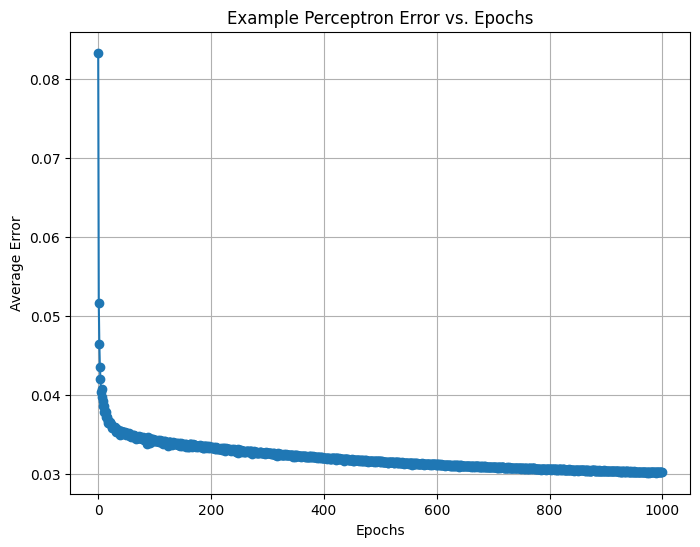

<ipython-input-3-82bdd7bed412>:72: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


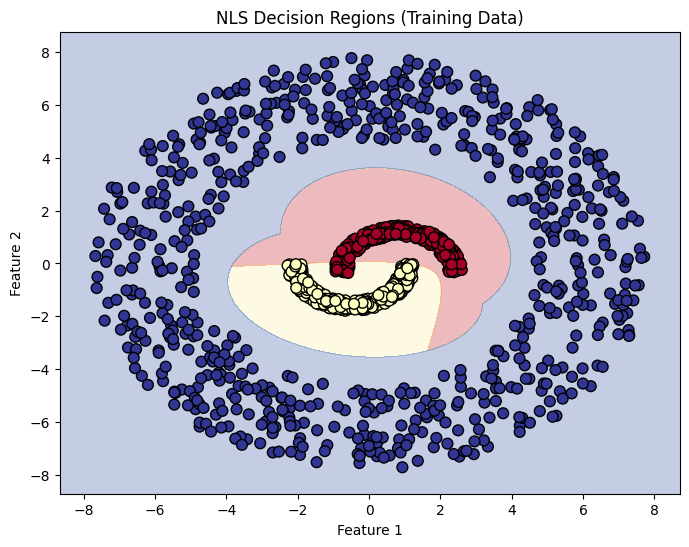

First 5 rows of X_train_nls:
 [[-5.424546 -4.892052]
 [-1.175635  7.082051]
 [ 0.22946  -6.775367]
 [ 1.068603  6.20411 ]
 [-2.59251   6.076352]]
First 5 rows of y_train_nls:
 [2 2 2 2 2]
First 5 rows of X_test_nls:
 [[ 1.787206  0.921857]
 [ 0.92523   1.276315]
 [ 4.825327  3.52583 ]
 [ 0.78977  -1.082666]
 [ 0.295041  1.111662]]
First 5 rows of y_test_nls:
 [0 0 2 1 0]

Confusion Matrix for NLS dataset:
[[138  12   0]
 [  0 150   0]
 [  0   0 300]]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# This function plots our data points in 2D.
def plot_data(X, y, title="Data", xlabel="Feature 1", ylabel="Feature 2"):
    plt.figure(figsize=(8, 6))
    classes = np.unique(y)
    colors = ['red', 'blue', 'green']

    # If we only have one feature, plot it against sample indices.
    if X.shape[1] == 1:
        for idx, cls in enumerate(classes):
            indices = np.where(y == cls)[0]
            plt.scatter(indices, X[indices, 0],
                        color=colors[idx % len(colors)], label=f"Class {cls}")
        plt.xlabel("Sample Index")
        plt.ylabel("Feature Value")
    else:
        for idx, cls in enumerate(classes):
            plt.scatter(X[y == cls, 0], X[y == cls, 1],
                        color=colors[idx % len(colors)], label=f"Class {cls}",
                        edgecolors='k', s=60)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    plt.title(title)
    plt.legend()
    plt.show()

# This function loads the NLS dataset from a text file.
# It skips the header row and assumes the file structure:
# first two columns are features, with 500 samples for class 0, 500 for class 1, and 1000 for class 2.
def load_nls_data(file_path):
    data = np.loadtxt(file_path, skiprows=1)
    X = data[:, :2]
    y = np.array([0] * 500 + [1] * 500 + [2] * 1000)
    return X, y

# File path for our NLS dataset. (Update this if needed.)
path_nls = '/content/drive/MyDrive/SharingFolder/CS671/Assign1/Dataset-1/NLS/dataset.txt'

# Load the NLS dataset.
X_nls, y_nls = load_nls_data(path_nls)

# Split the dataset into 70% training and 30% testing, preserving class ratios.
X_train_nls, X_test_nls, y_train_nls, y_test_nls = train_test_split(
    X_nls, y_nls, test_size=0.3, random_state=42, stratify=y_nls)

# Let’s visualize the original data for both training and testing.
plot_data(X_train_nls, y_train_nls, title="NLS Training Data")
plot_data(X_test_nls, y_test_nls, title="NLS Test Data")

# This function transforms our 2D features into a higher-dimensional space.
# For each sample [x1, x2], it returns [x1, x2, x1^2, x2^2, x1*x2].
# This helps a linear classifier capture nonlinearity in the data.
def transform_features(X):
    x1 = X[:, 0].reshape(-1, 1)
    x2 = X[:, 1].reshape(-1, 1)
    return np.hstack((X, x1**2, x2**2, x1 * x2))

# Apply the nonlinear transformation to both training and testing data.
X_train_nls_trans = transform_features(X_train_nls)
X_test_nls_trans  = transform_features(X_test_nls)

print("Original feature shape:", X_train_nls.shape)
print("Transformed feature shape:", X_train_nls_trans.shape)

# Define a sigmoid function for activation.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# And its derivative, which we'll need for backpropagation.
def sigmoid_derivative(output):
    return output * (1 - output)

# This is our simple perceptron model.
# It uses sigmoid activation and performs gradient descent with backpropagation.
class Perceptron:
    def __init__(self, input_size, learning_rate=0.01, epochs=1000, tol=1e-4):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol  # Stop early if error gets very low.
        self.weights = np.random.randn(input_size) * 0.01  # Small random weights.
        self.bias = np.random.randn() * 0.01  # Small random bias.
        self.errors = []  # To record error at each epoch.

    def forward(self, X):
        return np.dot(X, self.weights) + self.bias

    def predict(self, X):
        return sigmoid(self.forward(X))

    def train(self, X, y):
        self.errors = []
        for epoch in range(self.epochs):
            # Shuffle the data at the start of each epoch.
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            total_error = 0
            for xi, yi in zip(X_shuffled, y_shuffled):
                output = self.predict(xi)
                error = yi - output
                total_error += error**2  # Use squared error.
                deriv = sigmoid_derivative(output)
                self.weights += self.learning_rate * error * deriv * xi
                self.bias += self.learning_rate * error * deriv
            avg_error = total_error / X.shape[0]
            self.errors.append(avg_error)
            if avg_error < self.tol:
                print(f"Early stopping at epoch {epoch}, Average Error: {avg_error}")
                break
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Average Error: {avg_error}")
        return self.errors

# This class implements a One-Against-One scheme,
# where we train a separate binary classifier for every pair of classes.
class OAO_Perceptron:
    def __init__(self, input_size, learning_rate=0.01, epochs=1000, tol=1e-4):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.classifiers = []  # Will store tuples: (class_i, class_j, perceptron).
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        # Loop over all unique pairs of classes.
        for i in range(len(self.classes_)):
            for j in range(i + 1, len(self.classes_)):
                # Select data for the two classes.
                idx = np.where((y == self.classes_[i]) | (y == self.classes_[j]))[0]
                X_pair = X[idx]
                y_pair = y[idx]
                # Convert the labels into binary: 0 for class_i, 1 for class_j.
                binary_labels = np.where(y_pair == self.classes_[i], 0, 1)
                perceptron = Perceptron(self.input_size, self.learning_rate, self.epochs, self.tol)
                print(f"Training classifier for classes {self.classes_[i]} vs {self.classes_[j]}")
                perceptron.train(X_pair, binary_labels)
                self.classifiers.append((self.classes_[i], self.classes_[j], perceptron))

    def predict(self, X):
        votes = np.zeros(len(self.classes_))
        # Each classifier votes for one of the classes.
        for (class_i, class_j, perceptron) in self.classifiers:
            pred = np.round(perceptron.predict(X))
            if pred == 0:
                votes[np.where(self.classes_ == class_i)[0][0]] += 1
            else:
                votes[np.where(self.classes_ == class_j)[0][0]] += 1
        return self.classes_[np.argmax(votes)]

    def predict_batch(self, X):
        return np.array([self.predict(x) for x in X])

    def accuracy(self, X, y):
        y_pred = self.predict_batch(X)
        return accuracy_score(y, y_pred) * 100

    def evaluate(self, X, y, dataset_name="Dataset"):
        y_pred = self.predict_batch(X)
        acc = accuracy_score(y, y_pred) * 100
        cm = confusion_matrix(y, y_pred)
        print(f"Accuracy on {dataset_name}: {acc:.2f}%")
        print(f"Confusion Matrix on {dataset_name}:\n{cm}")
        return acc, cm

# This function plots the decision boundaries.
def plot_decision_regions(model, X, y, title="Decision Regions", resolution=0.1):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = model.predict_batch(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdYlBu, s=60)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# This function applies our nonlinear mapping to a grid,
# allowing us to visualize decision boundaries in the original input space.
def plot_decision_regions_transformed(model, X, y, transform_func, title="Decision Regions", resolution=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid_original = np.c_[xx.ravel(), yy.ravel()]
    grid_trans = transform_func(grid_original)
    Z = model.predict_batch(grid_trans)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdYlBu, s=60)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# ----- Start processing the Nonlinearly Separable (NLS) data -----
print("----- Processing Nonlinearly Separable Data -----")

# Visualize the original NLS data.
plot_data(X_train_nls, y_train_nls, title="NLS Training Data")
plot_data(X_test_nls, y_test_nls, title="NLS Test Data")

# Transform the NLS data into a higher-dimensional space.
print("Original feature shape:", X_train_nls.shape)
print("Transformed feature shape:", X_train_nls_trans.shape)

# Train the One-Against-One Perceptron model on the transformed data.
input_size_transformed = X_train_nls_trans.shape[1]
oao_perceptron_nls = OAO_Perceptron(input_size=input_size_transformed, learning_rate=0.1, epochs=1000, tol=1e-4)
oao_perceptron_nls.fit(X_train_nls_trans, y_train_nls)

# Evaluate the model on the transformed test set.
acc_nls, cm_nls = oao_perceptron_nls.evaluate(X_test_nls_trans, y_test_nls, dataset_name="NLS Test Data")

# Optionally, plot the error curve for one of the classifiers.
if oao_perceptron_nls.classifiers:
    _, _, example_perceptron = oao_perceptron_nls.classifiers[0]
    plt.figure(figsize=(8, 6))
    plt.plot(example_perceptron.errors, marker='o')
    plt.title("Example Perceptron Error vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Average Error")
    plt.grid(True)
    plt.show()

# Visualize decision regions in the original input space.
plot_decision_regions_transformed(oao_perceptron_nls, X_train_nls, y_train_nls, transform_features,
                                  title="NLS Decision Regions (Training Data)")

# Finally, inspect a few samples and print the confusion matrix.
print("First 5 rows of X_train_nls:\n", X_train_nls[:5])
print("First 5 rows of y_train_nls:\n", y_train_nls[:5])
print("First 5 rows of X_test_nls:\n", X_test_nls[:5])
print("First 5 rows of y_test_nls:\n", y_test_nls[:5])
print("\nConfusion Matrix for NLS dataset:")
print(cm_nls)